# File Info

Training for functions for neural odes. v1 contains training data segmented into pairs. This training failed. 

In [1]:
import os
import sys
from torchdiffeq import odeint as odeint

sys.path.append(os.path.abspath(".."))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import models.Neural_ODEs_v1 as nodes
import models.DynamicalSystems as ds

# Data Generation



In [2]:
lc = ds.Hopf(rho=1.0, alpha=-1.0, beta=0.0)

In [ ]:
a = torch.arange(-2.0, 2.0, 1.0); c = torch.ones_like(a)

r_vals = torch.arange(1, 5.0, 1.0)
ic = torch.cartesian_prod(a, a, r_vals)  #traj, dim

lc.gamma = 0.1
lc.f = lc.na_f

t_span = (0, 10); dt = 0.05
ic.shape #traj, dim

sol = lc.solve(x0=ic, t_span=t_span, dt=dt) #(time, traj, dim  )

time = torch.arange(t_span[0], t_span[1], dt).unsqueeze(1).unsqueeze(2)  #(time, 1, 1)

data_tensor = torch.stack((sol[0:-4, :, :], sol[1:-3, :, :]), dim=1)
time.shape

In [ ]:
list = []
for i in range(data_tensor.shape[2]):
    list.append(data_tensor[:,:,i,:])

data_tensor = torch.concat(list, dim=0)
data_loader = torch.utils.data.DataLoader(data_tensor, batch_size=64, shuffle=True)

In [ ]:
data_loader.dataset.shape #Num pairs - traj - dim

torch.Size([12544, 2, 3])

# Model 

In [21]:
class Trainer:
    def __init__(self, model, data_loader, optimizer, loss_fn, t_eval):
        self.model = model
        self.data_loader = data_loader
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.t_eval = t_eval
        self.loss_list = []
        self.epoch_trained = 0

        pred_x = odeint(func=self.model, y0=data_loader.dataset[:, 0, :], t=self.t_eval, method='rk4', options={'step_size': dt})
        loss = self.loss_fn(pred_x[-1, :, :], data_loader.dataset[:, 1, :])
        self.loss_list.append(loss.item())

    def train(self, num_epochs, t_eval, dt):
        
        for epoch in tqdm(range(num_epochs), desc= "Current Loss: " + str(self.loss_list[-1]) + "  - Epochs: " + str(self.epoch_trained)):
            self.epoch_trained += 1
            epoch_loss = 0.0
            for i, (x_batch) in enumerate(self.data_loader): #x_batch shape (num_traj, 2, dim)

                self.optimizer.zero_grad()
                
                #ODE integration to get predictions + compute loss
                pred_x = odeint(func=self.model, y0=x_batch[:, 0, :], t=self.t_eval, method='rk4', options={'step_size': dt})
                loss = self.loss_fn(pred_x[-1, :, :], x_batch[:, 1, :])
                epoch_loss += loss.item()
                
                #Backpropagation and optimization step
                loss.backward()
                self.optimizer.step()

            avg_epoch_loss = epoch_loss / len(self.data_loader)
            self.loss_list.append(avg_epoch_loss)
    

In [22]:
model = nodes.NODE2(input_dim=3, output_dim=3, hidden_dim=32, depth=4, activation_func=nn.Tanh())

In [ ]:
t_eval = torch.arange(0, 0.1, dt)
t_eval

#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

tensor([0.0000, 0.0500])

In [ ]:
trainer = Trainer(model=model, data_loader=data_loader, optimizer=optimizer, loss_fn=loss_fn, t_eval=t_eval)



In [29]:
trainer.train(num_epochs=400, t_eval=t_eval, dt=dt)

Current Loss: 7.17272563122151e-07  - Epochs: 100: 100%|██████████| 400/400 [06:00<00:00,  1.11it/s]


In [30]:
trainer.epoch_trained

500

Text(0.5, 0, 'Epochs')

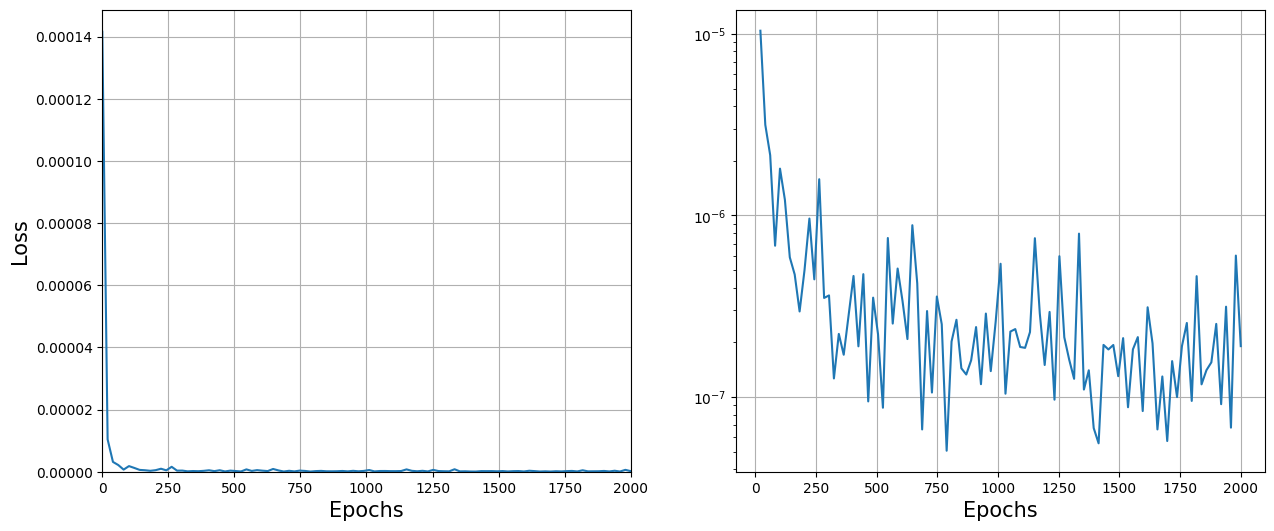

In [ ]:
### Analysis  
epochs = len(loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs*20, len(loss_list)), loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs*20)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs*20, len(loss_list))
ax2.plot(e_pts[1:], loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [23]:
pred_x.shape

torch.Size([2, 64, 3])

In [31]:
pred_x = odeint(func=model, y0=data_loader.dataset[:,0,:], t=t_eval, method='rk4', options={'step_size': dt})  #(time, batch, traj, dim)
loss = loss_fn(pred_x[-1, :, :, ], data_loader.dataset[:,1,:]) 
loss_list.append(loss.item())
print(f'Final Loss: {loss.item()}')

Final Loss: 0.0027553653344511986


# Analyzing the trained model

## Data Generation with trained NODE

In [32]:
a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  
c = torch.arange(-1, 8.0, 0.1)

pts = torch.cartesian_prod(a, b, c)  # (num_pts, dim)
pts.shape
t_Start_pred = 0; t_Final_pred = 40; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)

In [33]:
pts.shape

torch.Size([9000, 3])

In [34]:


node_data = odeint(func=model, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})



node_data = node_data.detach().numpy()
true_data = true_data.detach().numpy()

print(node_data.shape); print(true_data.shape)

(800, 9000, 3)
(800, 9000, 3)


## Plotting phase space

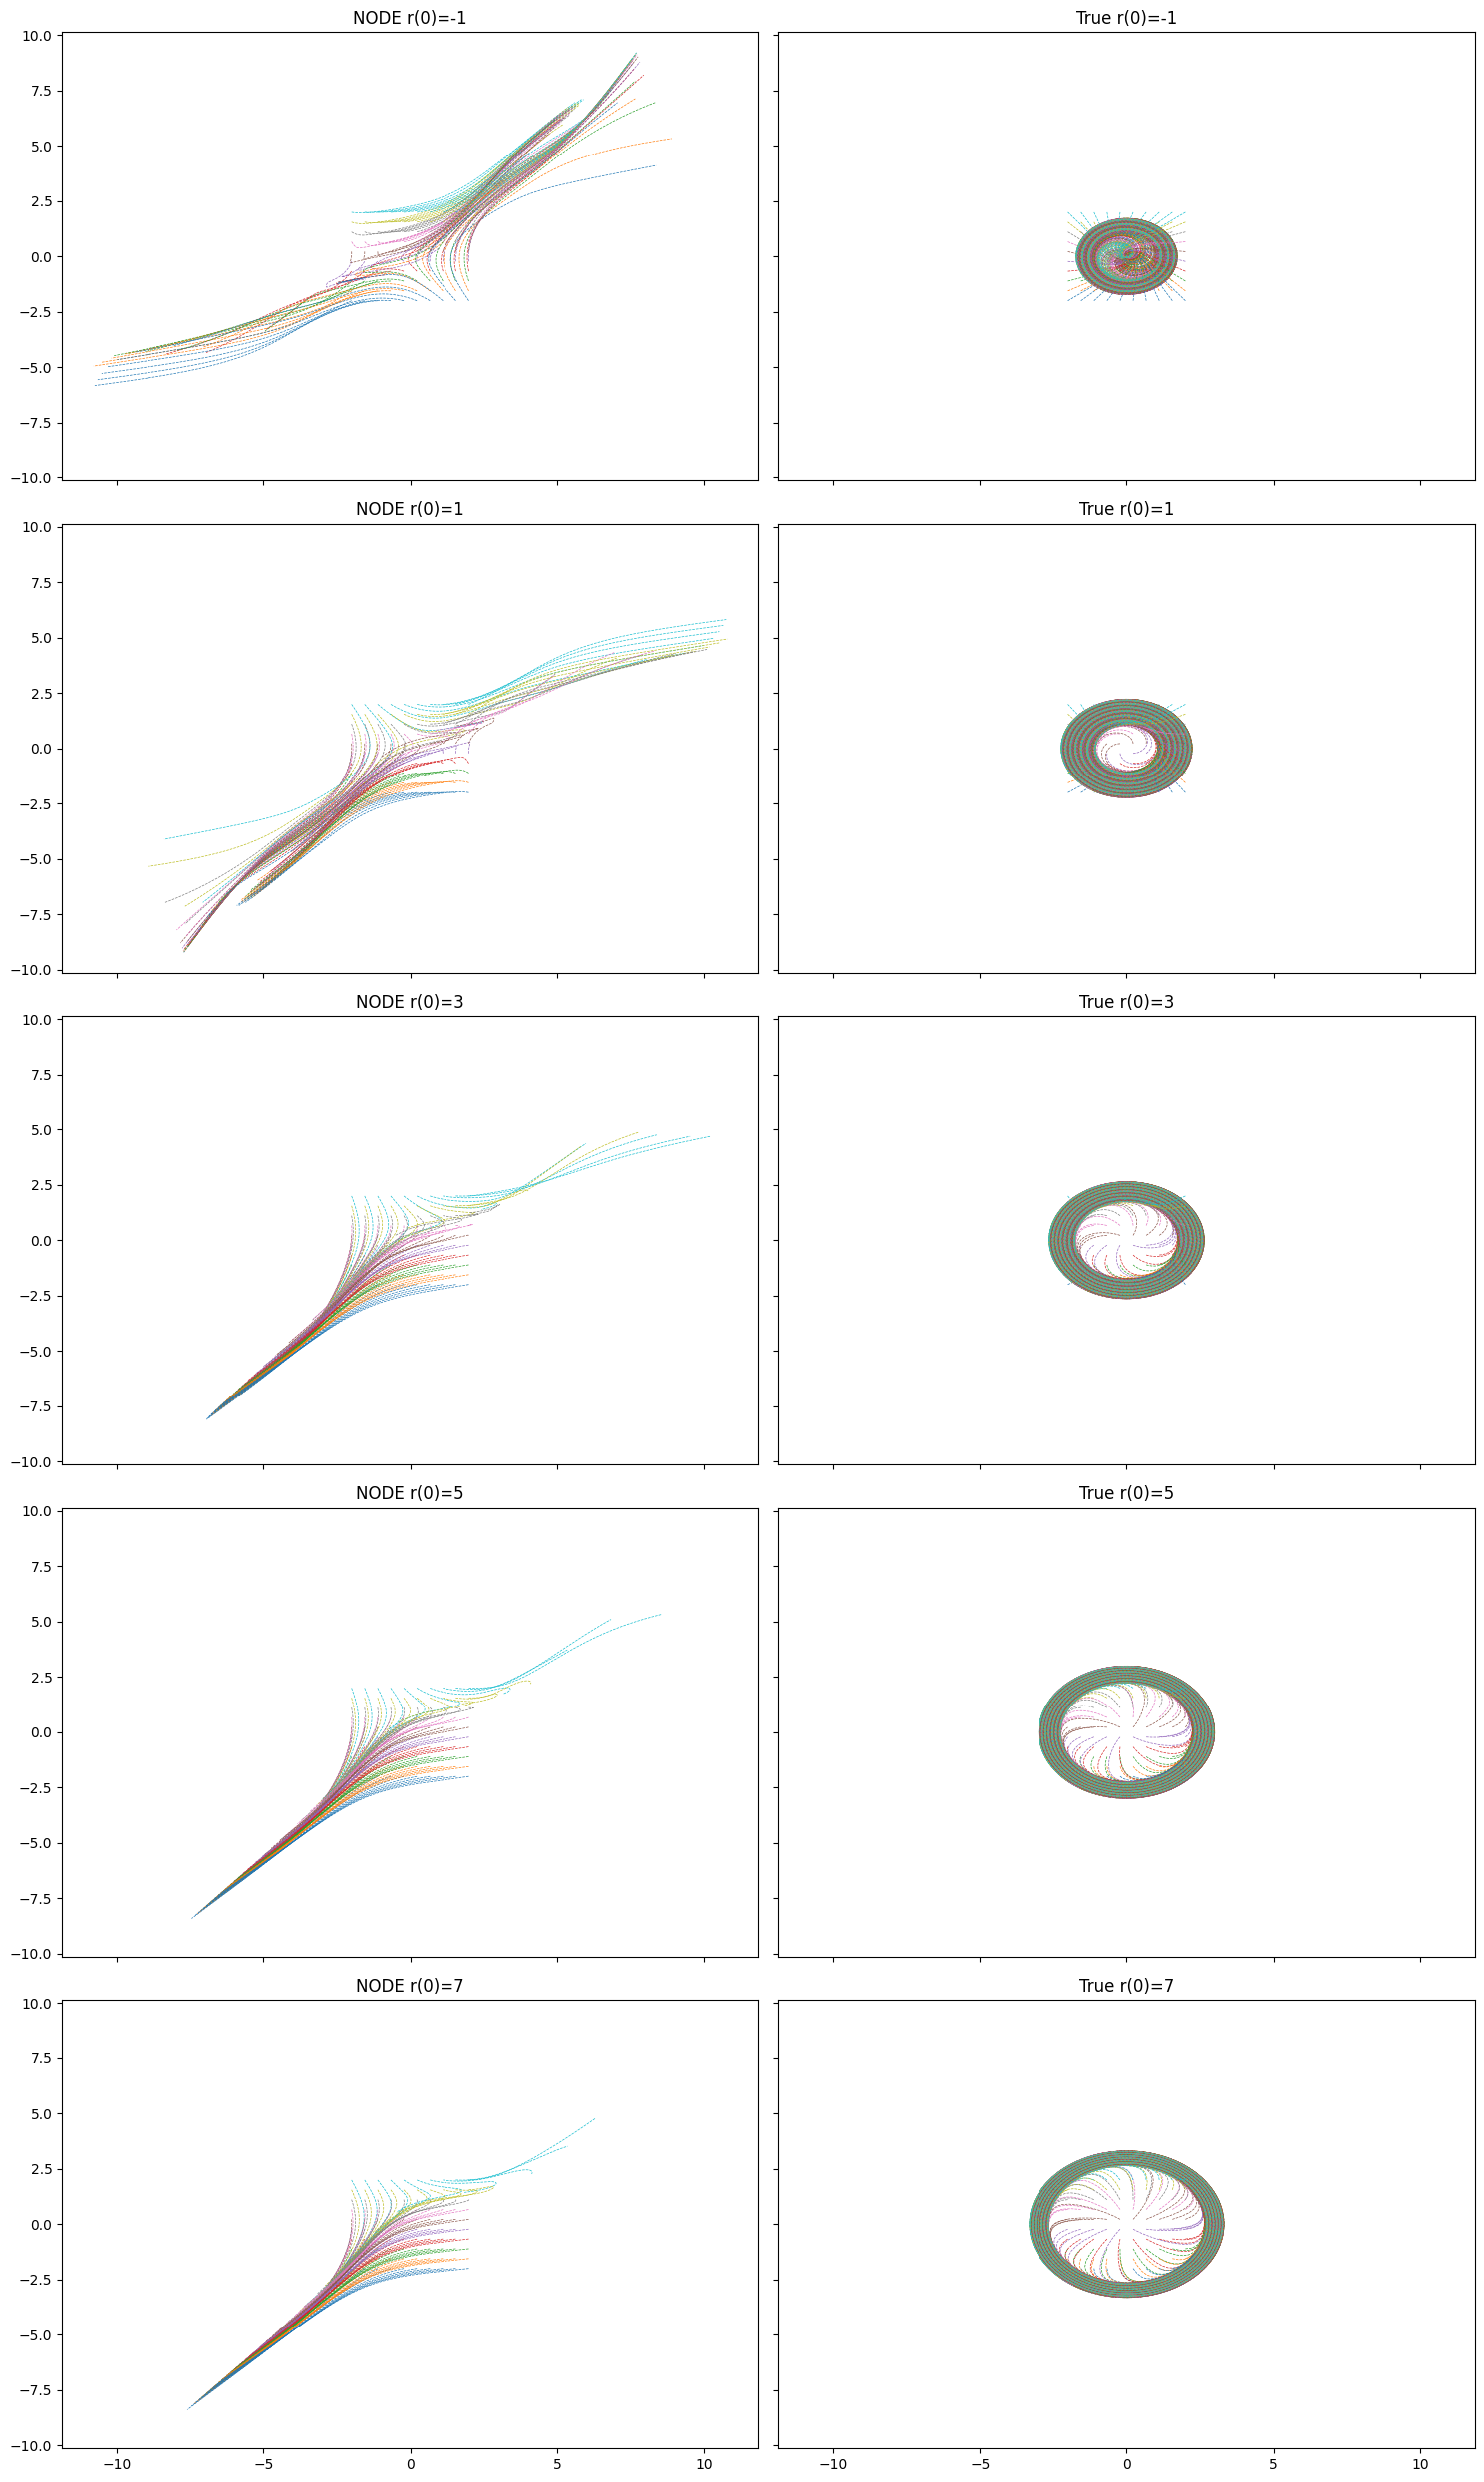

In [35]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0],
                    node_data[:, pts[:, 2] == r, 1],
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0],
                    true_data[:, pts[:, 2] == r, 1],
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'X')

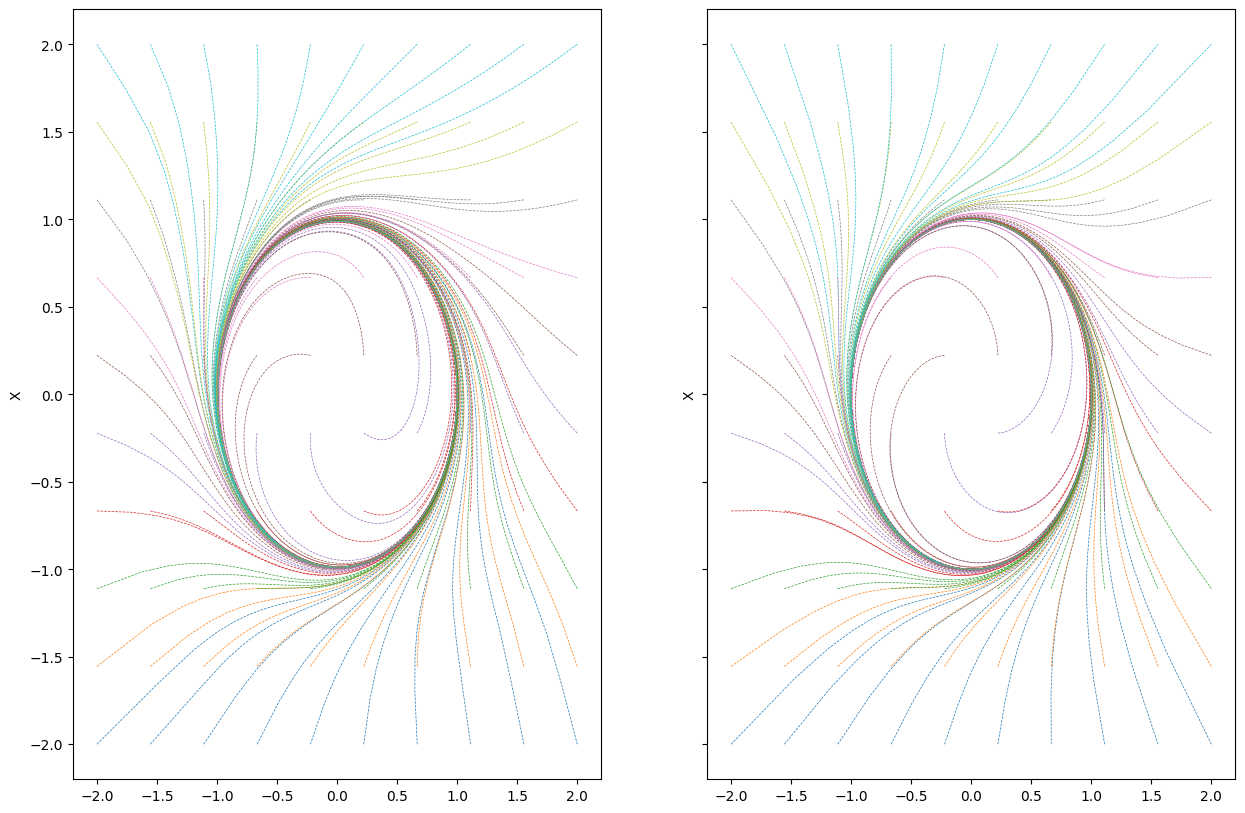

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True, sharey=True)

axes[0].plot(node_data[:, :, 0],
                node_data[:, :, 1],
                linewidth=0.5, alpha=1, linestyle='--')
axes[0].set_ylabel('X')


axes[1].plot(true_data[:, :, 0],
                true_data[:, :, 1],
                linewidth=0.5, alpha=1, linestyle='--')
axes[1].set_ylabel('X')

In [ ]:
# Plotting time traces: 

In [36]:
traj = 50
t = t_eval_pred.detach().numpy()
x = node_data[:, traj, :]
x_true = true_data[:, traj, :]



In [37]:
def cartesian_to_polar(x, y):
    """
    Convert Cartesian coordinates to polar coordinates.
    
    Parameters:
    x, y: float or array-like
        Cartesian coordinates
    
    Returns:
    r: float or array
        Radius (distance from origin)
    theta: float or array
        Angle in radians (from positive x-axis)
    """
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar_to_cartesian(r, theta):
    """
    Convert polar coordinates to Cartesian coordinates.
    
    Parameters:
    r: float or array-like
        Radius (distance from origin)
    theta: float or array-like
        Angle in radians (from positive x-axis)
    
    Returns:
    x, y: float or array
        Cartesian coordinates
    """
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

In [38]:

r, theta = cartesian_to_polar(x[:, 0], x[:, 1])
r_true, theta_true = cartesian_to_polar(x_true[:, 0], x_true[:, 1])

C:\Users\jackr\AppData\Local\Temp\ipykernel_30848\3089097437.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0, 1].legend()


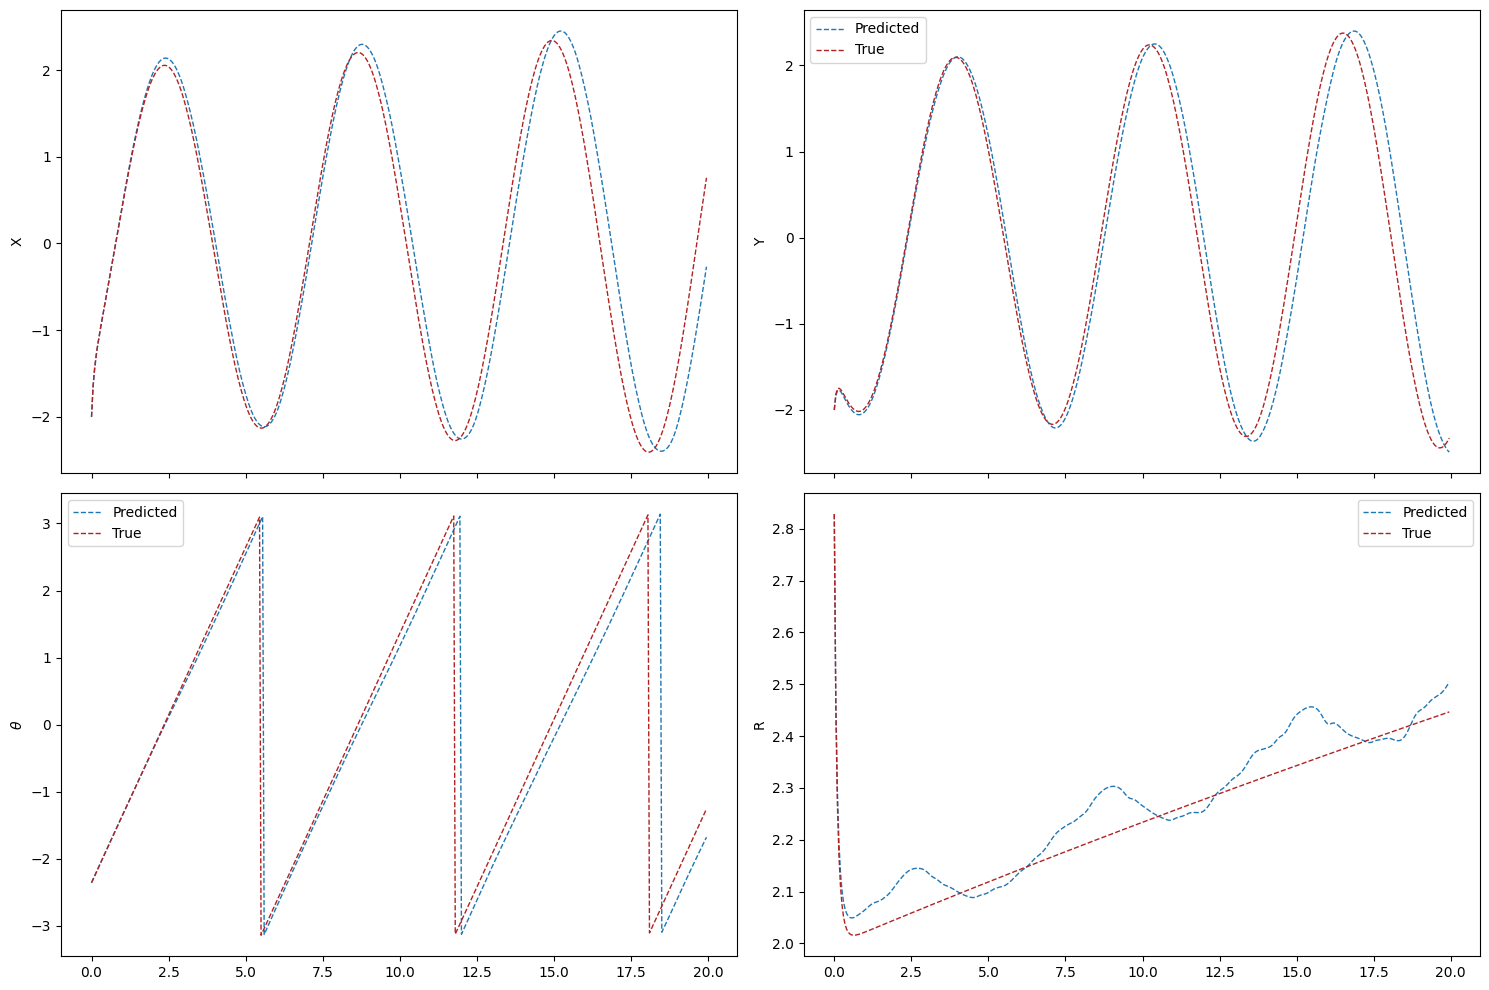

In [39]:


fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True, sharey=False)


axes[0, 0].plot(t,
                x[:, 0],
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[0, 0].plot(t, x_true[:, 0],
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[0, 0].set_ylabel('X')

axes[0, 1].legend()


axes[0, 1].plot(t,
                x[:, 1],
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[0, 1].plot(t, x_true[:, 1],
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[0, 1].set_ylabel('Y')
axes[0, 1].legend()

axes[1, 1].plot(t,
                r,
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[1, 1].plot(t, r_true,
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[1, 1].set_ylabel('R')
axes[1, 1].legend()


axes[1, 0].plot(t,
                theta,
                linewidth=1, alpha=1, linestyle='--', label='Predicted')
axes[1, 0].plot(t, theta_true,
                linewidth=1, alpha=1, linestyle='--', label='True', color='firebrick')
axes[1, 0].set_ylabel(r'$\theta$')
axes[1, 0].legend()
plt.tight_layout()
plt.show()